## <center>Assignment 3</center>

### Deadline  Aug 3 ,  2022

## <center>Assignment 3</center>

### Deadline  June 15 ,  2023



## Problem setup

#### Problem

In  assignment 3 a binary classification is to assign customers into good or bad categories based on  prediction. Thus, you will build models and answer questions using real word data to  predict whether the customer repay their credit within 90 days. 

#### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
sns.set()

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
#the function that will replace NaN values with the median for each column.
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table 

Now, read the data:

In [3]:
data = pd.read_csv('data/credit.csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/credit.csv'

Look at the variable types:

In [11]:
data=pd.read_csv('/home/abe/Downloads/ML/nati note/ass lest/Assignment3.csv')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [10]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check the class balance:

Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

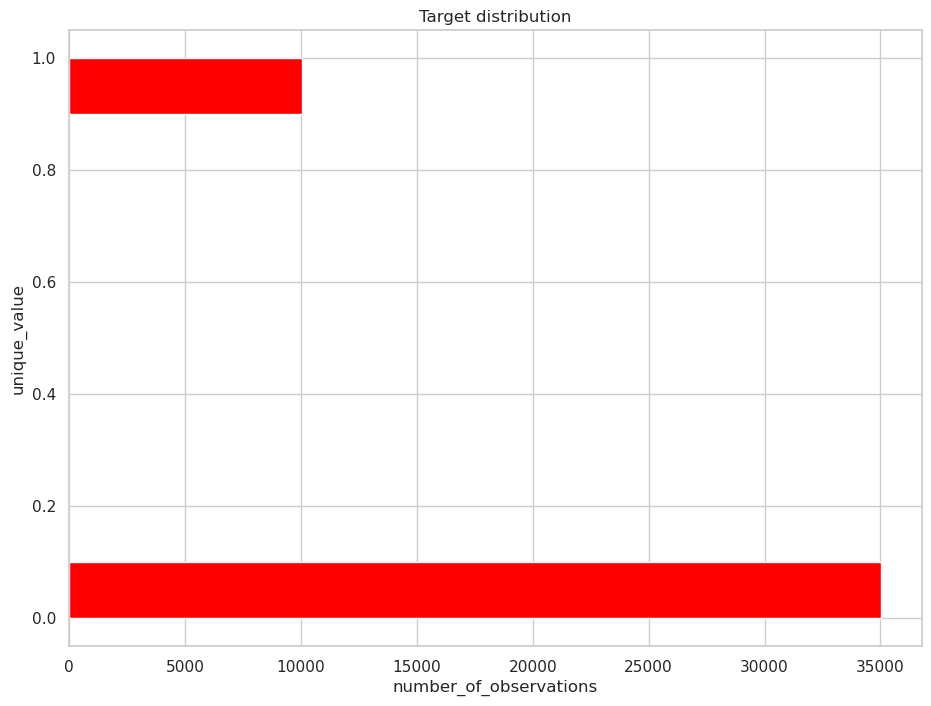

In [12]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Separate the input variable names by excluding the target:

In [13]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Apply the function to replace *NaN* values:

In [18]:
table = fill_nan(data)

Separate the target variable and input features:

In [19]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

## Bootstrapping

**Question 1.** Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use `np.random.seed(0)` as before. What is the resulting interval estimate?

1. 52.59 – 52.86
2. 45.71 – 46.13
3. 45.68 – 46.17
4. 52.56 – 52.88

In [21]:

def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Make an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the ages of those who let a delay
churn = data[data['SeriousDlqin2yrs'] == 1]['age'].values

# Set the random seed for reproducibility 
np.random.seed(0)

# Generate bootstrap samples and calculate the mean for each sample
# YOUR CODE HERE
#raise NotImplementedError()
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn, 1000)]
# Print the interval estimate for the sample means
print("Mean interval", stat_intervals(churn_mean_scores, 0.1))


Mean interval [45.71379414 46.12700479]


In [ ]:
assert stat_intervals(churn_mean_scores, 0.1).sum() >= 90

## Logistic regression
Now, we will create a `LogisticRegression` model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [22]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [23]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this: 

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model. impliment a **Grid Search** with the scoring metric **"roc_auc"** for the parameter `C` and **StratifiedKFold** cross-validation.

In [26]:
## use variable name grid_search
# YOUR CODE HERE
grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring='roc_auc', cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_
# raise NotImplementedError()


/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [27]:
assert grid_search.best_params_['C'] == 0.001

Can we consider the best model stable? The model is *stable* if the standard deviation on validation is less than 0.5%. Save the *ROC AUC* value of the best model; it will be useful for the following tasks.

1. Yes
2. No

In [28]:
grid_search.cv_results_['std_test_score'][1]

0.008137559189742445

In [29]:
print(grid_search.best_score_*100)

80.89120626797153


## Feature importance with Logistic Regression

 *Feature importance* is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them and use logistic regression to fit the X,y dataset. What is the most important feature for the best logistic regression model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [30]:
# YOUR CODE HERE
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)
# raise NotImplementedError()
pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


In [31]:
a =pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)
assert round(a.coef.sum(), 4) == 0.9313

Calculate how much `DebtRatio` affects our prediction using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). What is its value?

1. 0.38
2. -0.02
3. 0.11
4. 0.24

In [32]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.11426375283065272


 Let's see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer's age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase?

1. -0.01
2. 0.70
3. 8.32
4. 0.66

In [33]:
np.exp(lr.coef_[0][0]*20)

0.0002401982634402717

## Random Forest

Import the Random Forest classifier:

In [34]:
from sklearn.ensemble import RandomForestClassifier

Initialize Random Forest with 100 trees and balance target classes:

In [35]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced')

We will search for the best parameters among the following values:

In [36]:
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

Also, we will use the stratified k-fold validation again. You should still have the `skf` variable.

How much higher is the **ROC AUC** of the best random forest model than that of the best logistic regression on validation?

1. 4%
2. 3%
3. 2%
4. 1%

In [38]:
# use rf_grid_search as a variablebest_score_rid Seard on random forest  model 
# YOUR CODE HERE
rf_grid_search = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc', cv=skf, verbose=True)
rf_grid_search = rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_ - grid_search.best_score_)
# raise NotImplementedError()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.026866475306627002
CPU times: user 12.3 s, sys: 2.08 s, total: 14.4 s
Wall time: 8min 31s


In [40]:
assert round(rf_grid_search.best_score_ - grid_search.best_score_,4) == 0.0268

AssertionError: 

What feature has the weakest impact in the Random Forest model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [41]:
# YOUR CODE HERE
independent_columns_names[np.argmin(rf_grid_search.best_estimator_.feature_importances_)]
pd.DataFrame({'feat': independent_columns_names,
              'coef': rf_grid_search.best_estimator_.feature_importances_}).sort_values(by='coef', ascending=False)
# raise NotImplementedError()

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.300290
3,NumberOfTimes90DaysLate,0.278749
4,NumberOfTime60-89DaysPastDueNotWorse,0.156534
0,age,0.115860
2,DebtRatio,0.076082
5,MonthlyIncome,0.057994
6,NumberOfDependents,0.014491


What is the most significant advantage of using *Logistic Regression* versus *Random Forest* for this problem?

1. Spent less time for model fitting;
2. Fewer variables to iterate;
3. Feature interpretability;
4. Linear properties of the algorithm.

## Bagging

Import modules and set up the parameters for bagging:

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`. What is the best *ROC AUC* you achieve?

1. 80.75%
2. 80.12%
3. 79.62%
4. 76.50%

In [43]:
# YOUR CODE HERE
bg = BaggingClassifier(LogisticRegression(class_weight='balanced'),
                       n_estimators=100, n_jobs=-1, random_state=42)
r_grid_search = RandomizedSearchCV(bg, parameters, n_jobs=-1, 
                                   scoring='roc_auc', cv=skf, n_iter=20, random_state=1,
                                   verbose=True)
r_grid_search = r_grid_search.fit(X, y)
#raise NotImplementedError()

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/

/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/

/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/

/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/home/abe/anaconda3/envs/

/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/abe/anaconda3/envs/geopandas_stable/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [ ]:
assert round(r_grid_search.best_score_, 1) == 0.8